# Imports and data loading

In [1]:
import os
os.chdir("/home2/jgcw74/l3_project")  # go to project root
import importlib

import helpers
import xai

torch_device = helpers.utils.get_torch_device()

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
import typing as t
from pathlib import Path
import json

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
AVAILABLE_MODELS = ("ResNet50", "ConvNeXtSmall", "SwinTransformerSmall")
pd.options.display.precision = 5
pd.options.display.max_colwidth = 20

## Load data into multi-indexed dataframe

In [4]:
dfs = dict()
for explainer_name in t.get_args(xai.EXPLAINER_NAMES):
    results_for_exp = dict()
    h5_output_path = helpers.env_var.get_project_root() / "results" / explainer_name / "evaluation_output.h5"
    store = pd.HDFStore(str(h5_output_path), mode="r")
    for key_name in store.keys():
        table_name = key_name.strip("/")
        df: pd.DataFrame = store[table_name]
        if df.isna().sum().sum() != 0:
            raise RuntimeError("A results table contains NaN values!")
        else:
            # adjust value in line with methodology formula
            df["output_completeness : preservation_check_conf_drop"] = 1 - df["output_completeness : preservation_check_conf_drop"]

            results_for_exp[table_name] = df
    dfs[explainer_name] = results_for_exp
    store.close()
for key in dfs.keys():
    print(f"{key}: {len(dfs[key])} tables loaded")

PartitionSHAP: 12 tables loaded
GradCAM: 12 tables loaded
KPCACAM: 12 tables loaded


In [5]:
# ew = pd.ExcelWriter("all_results_export.xlsx")
big_df_dict = dict()
for sheet_name, df_dict in dfs.items():
    temp_df = pd.concat(df_dict).reset_index()
    temp_df["dataset"] = temp_df["level_0"].str.split("_").str.get(0)
    temp_df["model"] = temp_df["level_0"].str.split("_").str.get(1)
    temp_df = temp_df.rename(columns={"level_1": "class_label"}).set_index(["dataset", "model", "class_label"]).drop(["level_0"], axis="columns")

    # temp_df.to_excel(ew, sheet_name=sheet_name, index=True, merge_cells=False)

    big_df_dict[sheet_name] = temp_df
# ew.close()

In [6]:
xai_ds_m_c_df = pd.concat(big_df_dict.values(), keys=big_df_dict.keys(), names=["xai_method"])
xai_ds_m_c_df = xai_ds_m_c_df.drop(
    columns=xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.startswith("continuity") | xai_ds_m_c_df.columns.str.endswith("l2_distance")]
)  # drop columns that are not being used for the analysis
xai_ds_m_c_df.columns = xai_ds_m_c_df.columns.str.replace("randomised_model_similarity", "random_sim").str.replace("adversarial_attack_similarity", "adv_attk_sim").str.replace("correctness", "COR").str.replace("output_completeness", "O-C").str.replace("contrastivity", "CON").str.replace("compactness", "COM").str.replace("spearman_rank", "SR").str.replace("top_k_intersection", "top_m").str.replace("structural_similarity", "ssim")
xai_ds_m_c_df = xai_ds_m_c_df.replace(-np.inf, np.nan)
xai_ds_m_c_df.columns, xai_ds_m_c_df.index[-1]

(Index(['COR : random_sim : SR', 'COR : random_sim : top_m',
        'COR : random_sim : ssim', 'COR : incremental_deletion_auc_ratio',
        'O-C : deletion_check_conf_drop', 'O-C : preservation_check_conf_drop',
        'CON : adv_attk_sim : SR', 'CON : adv_attk_sim : top_m',
        'CON : adv_attk_sim : ssim', 'COM : threshold_score'],
       dtype='object'),
 ('KPCACAM', 'UCMerced', 'SwinTransformerSmall', 'tenniscourt'))

In [9]:
xai_ds_m_c_df.head(10)

COR : random_sim : SR  \
xai_method    dataset   model         class_label                                   
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523     
                                      Forest                           -0.07230     
                                      HerbaceousVegetation             -0.04666     
                                      Highway                          -0.10270     
                                      Industrial                        0.02080     
                                      Pasture                          -0.08098     
                                      PermanentCrop                     0.01643     
                                      Residential                      -0.01304     
                                      River                             0.08319     
                                      SeaLake                           0.13131     

                                                            COR : random_sim : top_m  \
xai_method    dataset   model         class_label                                      
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.14878        
                                      Forest                            0.07800        
                                      HerbaceousVegetation              0.10900        
                                      Highway                           0.10998        
                                      Industrial                        0.12305        
                                      Pasture                           0.13545        
                                      PermanentCrop                     0.12518        
                                      Residential                       0.08723        
                                      River                             0.24618        
                                      SeaLake                           0.19157        

                                                            COR : random_sim : ssim  \
xai_method    dataset   model         class_label                                     
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.41432       
                                      Forest                            0.40101       
                                      HerbaceousVegetation              0.39492       
                                      Highway                           0.37283       
                                      Industrial                        0.39885       
                                      Pasture                           0.38855       
                                      PermanentCrop                     0.39428       
                                      Residential                       0.37242       
                                      River                             0.44647       
                                      SeaLake                           0.44517       

                                                            COR : incremental_deletion_auc_ratio  \
xai_method    dataset   model         class_label                                                  
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.96003                    
                                      Forest                            0.99792                    
                                      HerbaceousVegetation              0.90204                    
                                      Highway                           0.21928                    
                                      Industrial                        0.57631                    
                                      Pasture                           0.77756                    
                                      PermanentCrop                     0.60866                    
                                     

# Sanity check correctness (COR : random_sim)

We want this to be low across all 3 similarity metrics if the explanation accurately reflects the model's behaviour.

In [22]:
cor_rs_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : random_sim")]
cor_rs_df: pd.DataFrame = xai_ds_m_c_df[cor_rs_cols].copy()
cor_rs_df["COR : random_sim : SR"] = cor_rs_df["COR : random_sim : SR"].abs()
cor_rs_df.head(10)

COR : random_sim : SR  \
xai_method    dataset   model         class_label                                   
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.00523     
                                      Forest                            0.07230     
                                      HerbaceousVegetation              0.04666     
                                      Highway                           0.10270     
                                      Industrial                        0.02080     
                                      Pasture                           0.08098     
                                      PermanentCrop                     0.01643     
                                      Residential                       0.01304     
                                      River                             0.08319     
                                      SeaLake                           0.13131     

                                                            COR : random_sim : top_m  \
xai_method    dataset   model         class_label                                      
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.14878        
                                      Forest                            0.07800        
                                      HerbaceousVegetation              0.10900        
                                      Highway                           0.10998        
                                      Industrial                        0.12305        
                                      Pasture                           0.13545        
                                      PermanentCrop                     0.12518        
                                      Residential                       0.08723        
                                      River                             0.24618        
                                      SeaLake                           0.19157        

                                                            COR : random_sim : ssim  
xai_method    dataset   model         class_label                                    
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.41432      
                                      Forest                            0.40101      
                                      HerbaceousVegetation              0.39492      
                                      Highway                           0.37283      
                                      Industrial                        0.39885      
                                      Pasture                           0.38855      
                                      PermanentCrop                     0.39428      
                                      Residential                       0.37242      
                                      River                             0.44647      
                                      SeaLake                           0.44517

<Axes: xlabel='xai_method,dataset'>

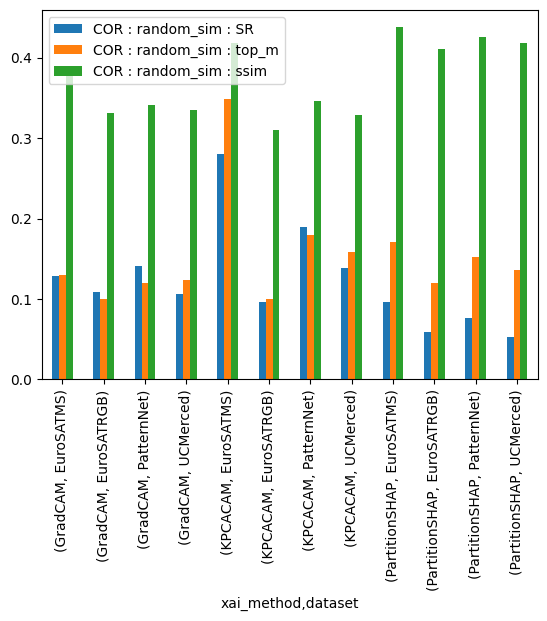

In [25]:
cor_rs_df.groupby(level=["xai_method", "dataset"]).mean().plot(kind="bar")

KPCA seems suspicious here on EuroSATMS

<Axes: xlabel='model'>

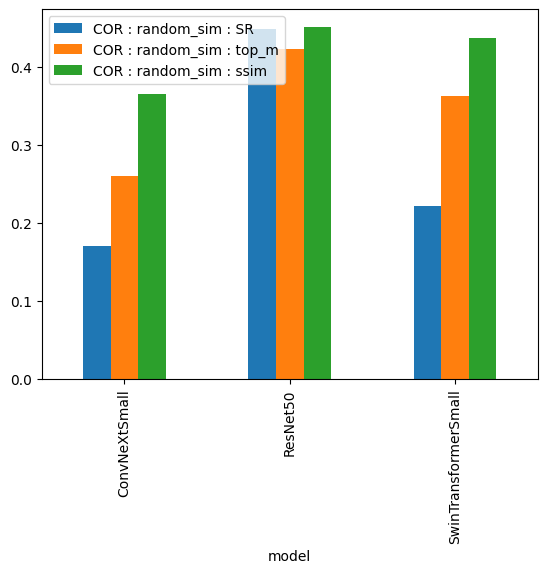

In [31]:
cor_rs_df.loc["KPCACAM", "EuroSATMS"].groupby("model").mean().plot(kind="bar")

Suggests that KPCACAM is not a faithful explainer for ResNet50 on EuroSATMS.

# Correctness (COR : incremental_deletion_auc_ratio)

We want this to be low (but might vary a lot by dataset and classes depending on object/land type) with 0 best and above 1 means random deletion was better.

In [32]:
cor_id_cols = xai_ds_m_c_df.columns[xai_ds_m_c_df.columns.str.contains("COR : incremental_deletion_auc_ratio")]
cor_id_df: pd.DataFrame = xai_ds_m_c_df[cor_id_cols].copy()
cor_id_df.head(10)

COR : incremental_deletion_auc_ratio
xai_method    dataset   model         class_label                                               
PartitionSHAP EuroSATMS ConvNeXtSmall AnnualCrop                        0.96003                 
                                      Forest                            0.99792                 
                                      HerbaceousVegetation              0.90204                 
                                      Highway                           0.21928                 
                                      Industrial                        0.57631                 
                                      Pasture                           0.77756                 
                                      PermanentCrop                     0.60866                 
                                      Residential                       0.45793                 
                                      River                             0.53516                 
                                      SeaLake                           0.99711

(0.0, 1.5)

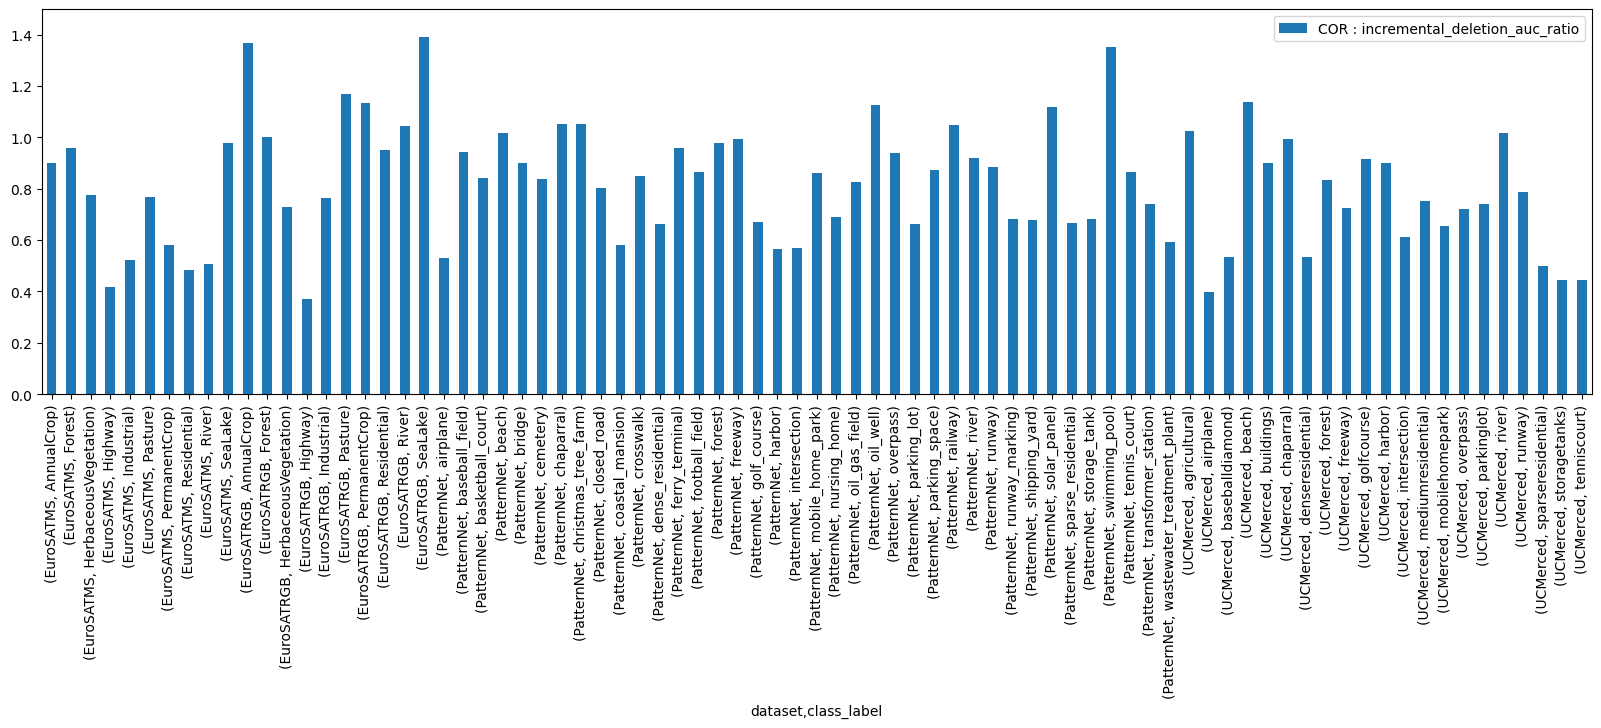

In [47]:
cor_id_df.loc["PartitionSHAP"].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5))
plt.ylim(0, 1.5)

(0.0, 1.5)

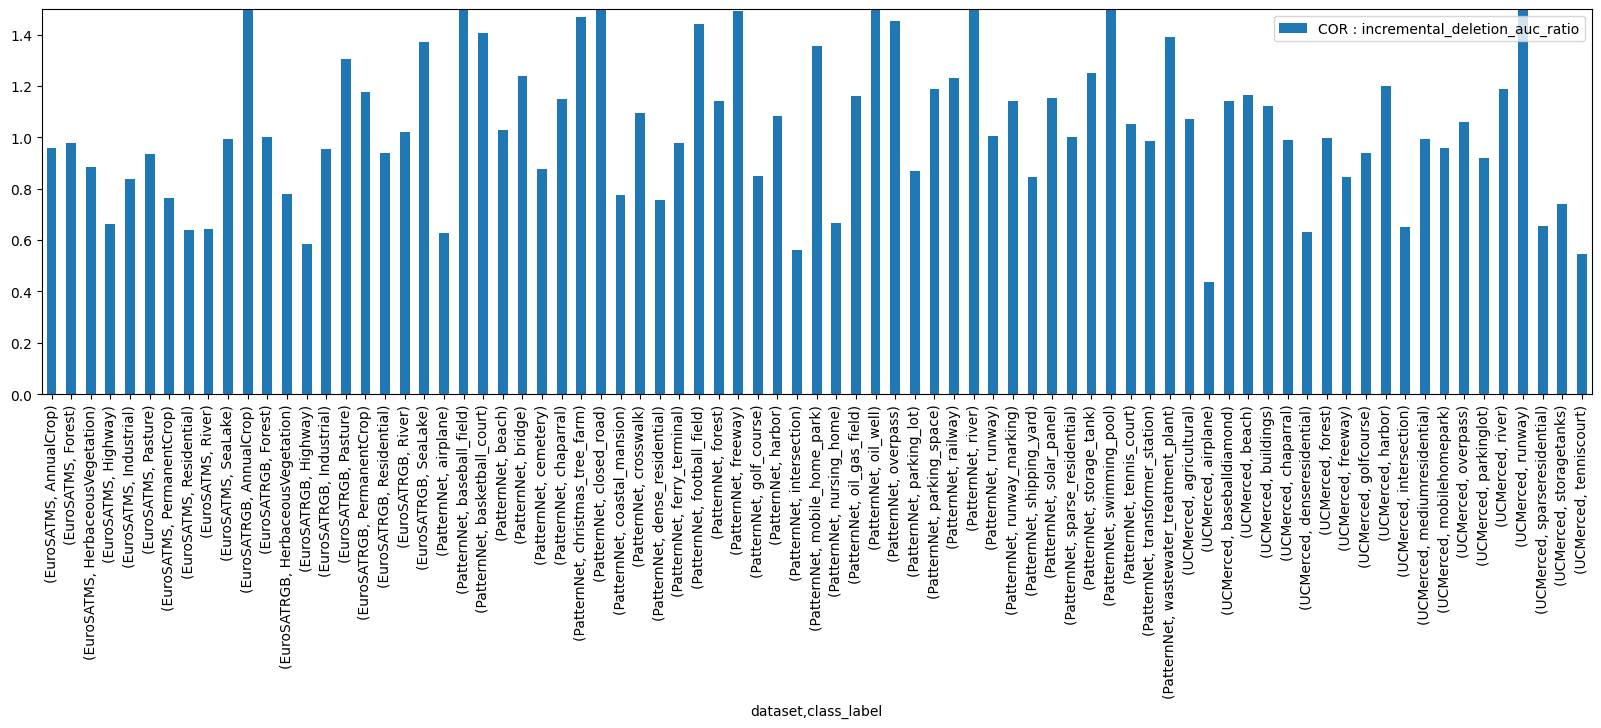

In [48]:
cor_id_df.loc["GradCAM"].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5))
plt.ylim(0, 1.5)

(0.0, 1.5)

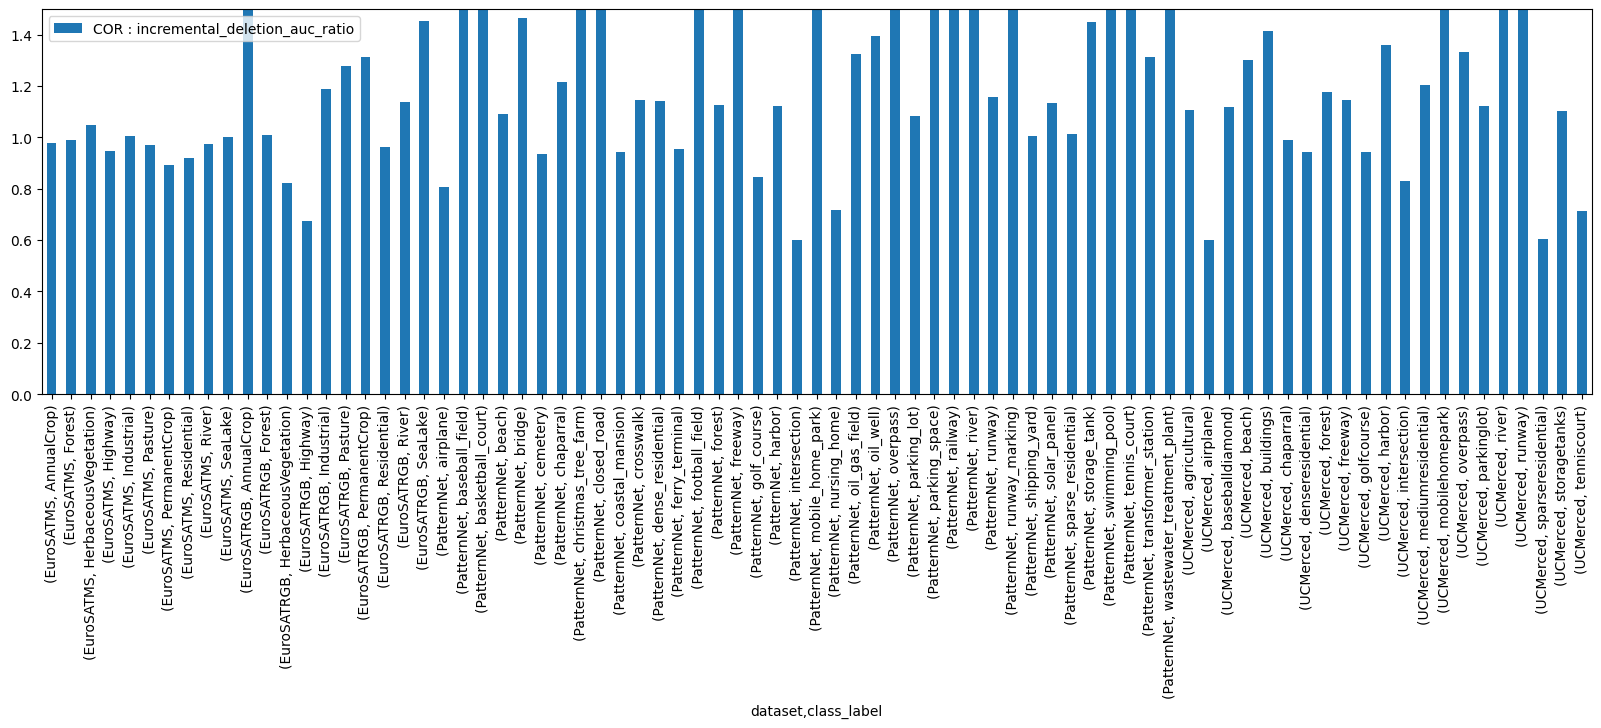

In [49]:
cor_id_df.loc["KPCACAM"].groupby(level=["dataset", "class_label"]).mean().plot(kind="bar", figsize=(20, 5))
plt.ylim(0, 1.5)

<Axes: title={'center': 'Hardest classes of incremental deletion'}, xlabel='dataset,class_label'>

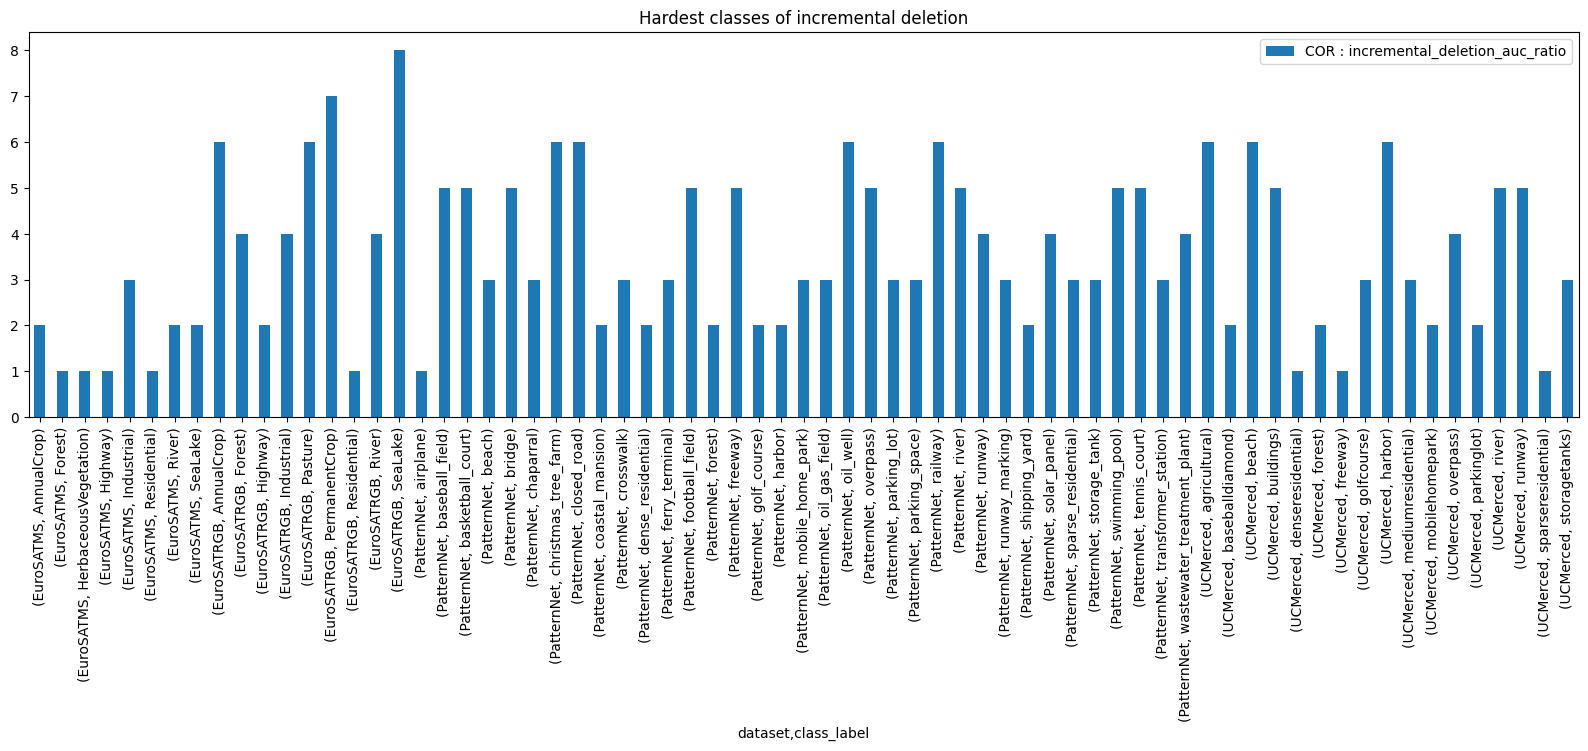

In [64]:
cor_id_df[cor_id_df > 1].dropna().groupby(["dataset", "class_label"]).count().plot(kind="bar", figsize=(20, 5), title="Hardest classes of incremental deletion")

In [68]:
cor_id_df.groupby(["xai_method"]).describe()

COR : incremental_deletion_auc_ratio                             \
                                             count     mean      std      min   
xai_method                                                                      
GradCAM                      237.0                  1.07417  0.66182  0.28518   
KPCACAM                      237.0                  1.23978  0.75818  0.30470   
PartitionSHAP                237.0                  0.81338  0.33677  0.21928   

                                                   
                   25%      50%      75%      max  
xai_method                                         
GradCAM        0.68965  0.89988  1.21619  5.98357  
KPCACAM        0.84281  0.99002  1.34524  6.35402  
PartitionSHAP  0.56973  0.76061  0.99408  2.51742

PartitionSHAP is the most reliable with a sub 1 incremental deletion ratio and lowest std. The UQ is also < 1.

Are the other two good for any datasets at all?

In [69]:
cor_id_df.groupby(["xai_method", "dataset"]).describe()

COR : incremental_deletion_auc_ratio           \
                                                        count     mean   
xai_method    dataset                                                    
GradCAM       EuroSATMS                  30.0                  0.82994   
              EuroSATRGB                 30.0                  1.11285   
              PatternNet                114.0                  1.19767   
              UCMerced                   63.0                  0.94859   
KPCACAM       EuroSATMS                  30.0                  0.97277   
              EuroSATRGB                 30.0                  1.16655   
              PatternNet                114.0                  1.36977   
              UCMerced                   63.0                  1.16656   
PartitionSHAP EuroSATMS                  30.0                  0.68926   
              EuroSATRGB                 30.0                  0.99250   
              PatternNet                114.0                  0.83876   
              UCMerced                   63.0                  0.74126   

                                                                                
                              std      min      25%      50%      75%      max  
xai_method    dataset                                                           
GradCAM       EuroSATMS   0.17327  0.45930  0.70656  0.89276  0.96929  1.06780  
              EuroSATRGB  0.60779  0.28518  0.81591  0.99190  1.33768  3.44704  
              PatternNet  0.81778  0.36703  0.69203  0.89959  1.45060  5.98357  
              UCMerced    0.43346  0.33335  0.66329  0.84833  1.06849  2.45857  
KPCACAM       EuroSATMS   0.09761  0.74759  0.94474  0.99080  1.00468  1.19147  
              EuroSATRGB  0.57141  0.30470  0.90431  1.00399  1.34805  3.33477  
              PatternNet  0.92951  0.36664  0.83759  0.98808  1.52479  6.35402  
              UCMerced    0.61853  0.33906  0.82170  0.98476  1.28504  3.30575  
PartitionSHAP EuroSATMS   0.23960  0.21928  0.52181  0.70970  0.91071  0.99972  
              EuroSATRGB  0.44885  0.26239  0.63781  0.95733  1.19169  2.02407  
              PatternNet  0.33836  0.25907  0.58642  0.79110  1.02910  2.51742  
              UCMerced    0.26929  0.29997  0.55163  0.72084  0.95354  1.36409

All methods seem better than random for EuroSATMS deletion. PatternNet is hard for GradCAM and KPCACAM.

Or good for any models?

In [70]:
cor_id_df.groupby(["xai_method", "model"]).describe()

COR : incremental_deletion_auc_ratio  \
                                                                  count   
xai_method    model                                                       
GradCAM       ConvNeXtSmall                        79.0                   
              ResNet50                             79.0                   
              SwinTransformerSmall                 79.0                   
KPCACAM       ConvNeXtSmall                        79.0                   
              ResNet50                             79.0                   
              SwinTransformerSmall                 79.0                   
PartitionSHAP ConvNeXtSmall                        79.0                   
              ResNet50                             79.0                   
              SwinTransformerSmall                 79.0                   

                                                                        \
                                       mean      std      min      25%   
xai_method    model                                                      
GradCAM       ConvNeXtSmall         1.00323  0.67785  0.33335  0.68258   
              ResNet50              1.49967  0.71879  0.36703  0.93292   
              SwinTransformerSmall  0.71962  0.18251  0.28518  0.57146   
KPCACAM       ConvNeXtSmall         1.05277  0.71095  0.33906  0.76556   
              ResNet50              1.77783  0.86767  0.38608  1.01619   
              SwinTransformerSmall  0.88873  0.16578  0.30470  0.83230   
PartitionSHAP ConvNeXtSmall         0.80129  0.33443  0.21928  0.58900   
              ResNet50              1.00639  0.34377  0.49901  0.77030   
              SwinTransformerSmall  0.63245  0.20518  0.24977  0.50383   

                                                               
                                        50%      75%      max  
xai_method    model                                            
GradCAM       ConvNeXtSmall         0.93757  1.07644  5.98357  
              ResNet50              1.41777  1.85434  3.58557  
              SwinTransformerSmall  0.70991  0.85114  1.02511  
KPCACAM       ConvNeXtSmall         0.98005  1.16459  6.35402  
              ResNet50              1.60475  2.44378  4.07367  
              SwinTransformerSmall  0.92686  0.98800  1.25877  
PartitionSHAP ConvNeXtSmall         0.75182  0.98680  1.90917  
              ResNet50              0.98186  1.22673  2.51742  
              SwinTransformerSmall  0.59518  0.77912  1.01339

GradCAM and KPCACAM are actually worst at ResNet with high mean and std??